<a href="https://colab.research.google.com/github/KseniiaTsyganova/annotators-bots-nlp-/blob/main/annotators_bots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy

In [ ]:
!pip install keras==2.6.*

In [ ]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-08-20 11:11:32.703752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-08-20 11:11:32.703797: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-20 11:11:35.477249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-08-20 11:11:35.477280: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-20 11:11:35.484343: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LAPTOP-S8RV4BPO
2022-08-20 11:11:35.484407: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LAPTOP-S8RV4BPO


In [ ]:
!pip install wordcloud

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
import numpy as np
import string

import time
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import Pool, CatBoostClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

import tensorflow as tf

from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K


In [ ]:
data = pd.read_csv('annotators.csv')

In [ ]:
data.head()

,Annotator ID,Text,Answer
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36417 entries, 0 to 36416
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Annotator ID  36417 non-null  object
 1   Text          36417 non-null  object
 2   Answer        36417 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 604.7+ KB


In [ ]:
data.isna().sum()

Annotator ID    0
Text            0
Answer          0
dtype: int64

In [ ]:
data.columns = ['annotator_id', 'text', 'answer']

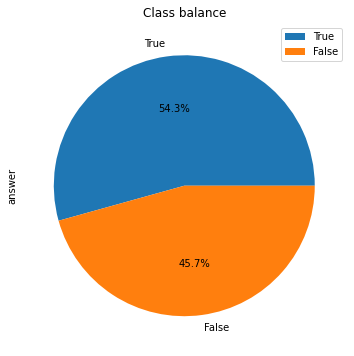

In [ ]:
plt.figure(figsize=(6, 6))
data.answer.value_counts(normalize = True).plot(kind = 'pie', autopct='%1.1f%%')
plt.title('Class balance')
plt.legend()
plt.show()

In [ ]:
nlp = spacy.load('en_core_web_sm') 

In [ ]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z \']', ' ', text).split()
    return " ".join(text)

In [ ]:
%time

data['clear_text'] = data['text'].apply(clear_text)

Wall time: 0 ns


In [ ]:
data.head()

,annotator_id,text,answer,clear_text
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True,cz binance Thanks for being upfront about this...
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True,cz binance Thanks for being upfront about this...
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True,cz binance Thanks for being upfront about this...
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False,cz binance The speed with which Binance has re...
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True,cz binance The speed with which Binance has re...


In [ ]:
%time

data['lemm_text'] = data['clear_text'].apply(lambda sentence: ' '.join([word.lemma_ for word in nlp(sentence.lower())]))

Wall time: 0 ns


In [ ]:
data.head()

,annotator_id,text,answer,clear_text,lemm_text
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True,cz binance Thanks for being upfront about this...,cz binance thank for be upfront about this cz ...
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True,cz binance Thanks for being upfront about this...,cz binance thank for be upfront about this cz ...
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True,cz binance Thanks for being upfront about this...,cz binance thank for be upfront about this cz ...
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False,cz binance The speed with which Binance has re...,cz binance the speed with which binance have r...
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True,cz binance The speed with which Binance has re...,cz binance the speed with which binance have r...


Now we will create word cloud to make sure that there are no non-lematized words left. 

In [ ]:
words = ' '.join(data['lemm_text'])

In [ ]:
cloud = WordCloud().generate(words)

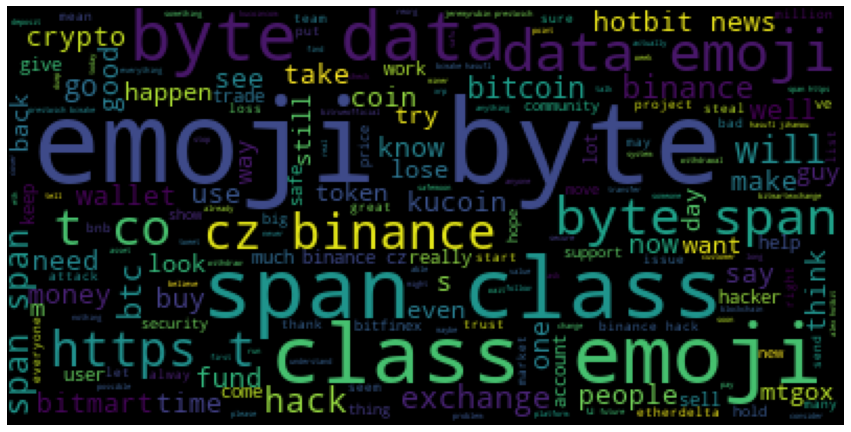

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

Now we can see that word 'will' hasn't been lematized.
Let's see if it is in stop-words.

Let's download dictionaries for lemmatization and for working with stop-words.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Админ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopwords = set(nltk_stopwords.words('english'))

In [ ]:
'will' in stopwords

True

This word is contained in the stop words, so we won't touch it, since it will be excluded during vectorization anyway.

Let's split our table into a target feature and a column with our lemmatized answers.

In [ ]:
target = data['answer'].astype(int)

In [ ]:
features = data['lemm_text']

Let's divide our tables into training and test in the ratio of 75:25.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify=target)

In [ ]:
lr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopwords)),
    ('lr_clf', LogisticRegression(random_state=42))
])

svc_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopwords)), 
    ('svc_clf', SVC(random_state=42, class_weight = 'balanced', kernel = 'linear'))
])

### Training

Let's make a function that writes down the results of our models to the table.

In [ ]:
models_table = pd.DataFrame(
columns = ['model_name', 'parametrs', 'F1 cross', 'AUC-PR train'])

In [ ]:
def add_model(model, model_name, parametrs, f1_score_cross, features=features_train):
    predictions_train = model.predict(features)
    return models_table.append(
    {'model_name': model_name,
    'parametrs': parametrs,
    'F1 cross': f1_score_cross,
     'AUC-PR train': average_precision_score(target_train, predictions_train),
    },
    ignore_index = True
    )

### Logistic Regression

Let's start training on the Logistic Regression model. Let's use GridSearchCV to iterate through the parameters.

In [ ]:
parameters = { 
              'lr_clf__solver':['lbfgs', 'liblinear'],
              'lr_clf__class_weight':[None, 'balanced'],
              'lr_clf__max_iter':range (4500, 6000, 500)
              }

In [ ]:
model_gs_lr = GridSearchCV(lr_ppl_clf, parameters, cv=3, scoring='f1', n_jobs=-1)

In [ ]:
%%time

model_gs_lr.fit(features_train, target_train)
model_gs_lr.best_params_

Wall time: 12.2 s


{'lr_clf__class_weight': None,
 'lr_clf__max_iter': 4500,
 'lr_clf__solver': 'lbfgs'}

We will write downthis found best model in our table.

In [ ]:
models_table = add_model(model_gs_lr, 'Logistic Regression', model_gs_lr.best_params_, model_gs_lr.best_score_)

In [ ]:
models_table

,model_name,parametrs,F1 cross,AUC-PR train
0,Logistic Regression,"{'lr_clf__class_weight': None, 'lr_clf__max_it...",0.669028,0.706589


### Support Vector Classification

Now let's move on to the SVC model.

In [ ]:
parametr_svc = {'svc_clf__C': [1, 2]}

In [ ]:
model_gs_svc = GridSearchCV(svc_ppl_clf, parametr_svc, cv=3, scoring='f1', n_jobs=-1)

In [ ]:
%%time

model_gs_svc.fit(features_train, target_train)
model_gs_svc.best_params_

Wall time: 8min 53s


{'svc_clf__C': 1}

In [ ]:
%%time

models_table = add_model(model_gs_svc, 'Support Vector classification', model_gs_svc.best_params_, model_gs_svc.best_score_)

Wall time: 2min 3s


In [ ]:
models_table

,model_name,parametrs,F1 cross,AUC-PR train
0,Logistic Regression,"{'lr_clf__class_weight': None, 'lr_clf__max_it...",0.669028,0.706589
1,Support Vector classification,{'svc_clf__C': 1},0.627320,0.723812


### CatBoostClassifier

Let's move on to the CatBoostClassifier gradient boosting model. For this model, we will not use TF-IDF feature vectorization, but let the model itself convert text into features.

In [ ]:
features_train = features_train.to_frame()

In [ ]:
train_pool = Pool(
features_train, 
target_train,
text_features = list(features_train),
feature_names = list(features_train)
)

Let's set the default values of the model.

In [ ]:
model_cat = CatBoostClassifier(
loss_function = 'Logloss',
random_state = 42,
eval_metric = 'F1',
verbose = 500
)

Let's use the grid method to find the best model parameters.

In [ ]:
grid = {'learning_rate': [0.03, 0.1],
       'depth': [4, 6, 10]}

In [ ]:
%%time

grid_search_result = model_cat.grid_search(grid, train_pool, cv=3)

0:	learn: 0.7053595	test: 0.6986660	best: 0.6986660 (0)	total: 160ms	remaining: 2m 40s
500:	learn: 0.7053595	test: 0.6986660	best: 0.6986660 (0)	total: 973ms	remaining: 969ms
999:	learn: 0.7053595	test: 0.6986660	best: 0.6986660 (0)	total: 1.72s	remaining: 0us

bestTest = 0.6986660314
bestIteration = 0

0:	loss: 0.6986660	best: 0.6986660 (0)	total: 2.27s	remaining: 11.3s
0:	learn: 0.7053595	test: 0.6986660	best: 0.6986660 (0)	total: 1.94ms	remaining: 1.93s
500:	learn: 0.7053595	test: 0.6986660	best: 0.6986660 (0)	total: 763ms	remaining: 760ms
999:	learn: 0.7053595	test: 0.6986660	best: 0.6986660 (0)	total: 1.7s	remaining: 0us

bestTest = 0.6986660314
bestIteration = 0

1:	loss: 0.6986660	best: 0.6986660 (0)	total: 3.99s	remaining: 7.97s
0:	learn: 0.7053595	test: 0.6986660	best: 0.6986660 (0)	total: 2.11ms	remaining: 2.11s
500:	learn: 0.7053595	test: 0.6986660	best: 0.6986660 (0)	total: 816ms	remaining: 812ms
999:	learn: 0.7053595	test: 0.6986660	best: 0.6986660 (0)	total: 1.58s	remaini

In [ ]:
model_cat.get_best_score()

{'learn': {'Logloss': 0.6013063883757569, 'F1': 0.7010252717484483}}

In [ ]:
models_table = add_model(
    model_cat,
    'Cat Boost Classifier',
    model_cat.get_param,
    0.7010252717484483,
    train_pool   
)

In [ ]:
models_table

,model_name,parametrs,F1 cross,AUC-PR train
0,Logistic Regression,"{'lr_clf__class_weight': None, 'lr_clf__max_it...",0.669028,0.706589
1,Support Vector classification,{'svc_clf__C': 1},0.627320,0.723812
2,Cat Boost Classifier,<bound method CatBoost.get_param of <catboost....,0.701025,0.696913


### RNN

Now we will try to solve the task with recurrent neural network (RNN) with Bidirectional LSTM layers.

Let's make function that will tokenize our text.

In [ ]:
data.head()

,annotator_id,text,answer,clear_text,lemm_text
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True,cz binance Thanks for being upfront about this...,cz binance thank for be upfront about this cz ...
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True,cz binance Thanks for being upfront about this...,cz binance thank for be upfront about this cz ...
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True,cz binance Thanks for being upfront about this...,cz binance thank for be upfront about this cz ...
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False,cz binance The speed with which Binance has re...,cz binance the speed with which binance have r...
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True,cz binance The speed with which Binance has re...,cz binance the speed with which binance have r...


Let's divide our data once again

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify=target)

Now we will store our index

In [ ]:
train_index = features_train.index

In [ ]:
test_index = features_test.index

In [ ]:
features_train

353      guy I be not sure if everyone understand this ...
29403    if the incentive line up to try a reorg cz bin...
6406     cryptoworld cz binance bitmart need your atten...
28734    this address hack m off kucoincom sad thing be...
13003    distribution to probit exchange hitbtc hotbit ...
                               ...                        
4716     cz binance this be the kind of behaviour that ...
15576    plastiks io bitmartexchange span class ' emoji...
17098          from discover on google https t co sze crac
8462     obviously I be not an influencer and my messag...
11315    smartbscnews pancakeswap lympo io nord finance...
Name: lemm_text, Length: 27312, dtype: object

In [ ]:
def tokenize_text(raw_text: str):
    
    tokenized_str = nltk.word_tokenize(raw_text)
    tokens = [i for i in tokenized_str if (i not in string.punctuation)]
    filtered_tokens = [i for i in tokens if (i not in stopwords)]
    return filtered_tokens

In [ ]:
features_train_tokens = [tokenize_text(i) for i in features_train.values]

Select unique words for the dictionary


In [ ]:
unique_tokens = set(np.concatenate(features_train_tokens))

Number of unique words in the dictionary

In [ ]:
len(unique_tokens)

25310

Create a dictionary, where each unique word corresponds to an integer number

In [ ]:
word_index = {v: k+3 for k, v in dict(enumerate(unique_tokens)).items()}

Add to the dictionary values corresponding to the padding, the beginning of the sentence and the unknown word

In [ ]:
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNKNOWN>'] = 2

Create functions to translate a sequence of tokens into their dictionary indexes and vice versa

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

def encode_review(words):
    words = ['<START>'] + words
    idxs = [word_index.get(word, word_index['<UNKNOWN>']) for word in words]
    return idxs

Let's prepare test features

In [ ]:
features_test_tokens = [tokenize_text(i) for i in features_test.values]

Encode training and test texts

In [ ]:
train_data = [encode_review(i) for i in features_train_tokens]
test_data = [encode_review(i) for i in features_test_tokens]

Find out the maximum chain length

In [ ]:
max_len = 0
for i in train_data:
    if len(i) > max_len:
        max_len = len(i)
        
print(max_len)

238


Let's make all chains the same length

In [ ]:
# Maximum sequence length

MAX_SEQ_LEN = max_len

print(MAX_SEQ_LEN)

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=MAX_SEQ_LEN
)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=MAX_SEQ_LEN
)


238


Let's build our RNN model and see its parametrs

In [ ]:
EMB_SIZE = 32 # Size of vector representation (embedding)

model =  tf.keras.Sequential([
                              tf.keras.layers.Embedding(len(word_index), EMB_SIZE),
                              tf.keras.layers.Bidirectional(
                                  tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
                              tf.keras.layers.Bidirectional(
                                  tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
                              tf.keras.layers.Bidirectional(
                                  tf.keras.layers.LSTM(128, return_sequences=True)),
                              tf.keras.layers.Bidirectional(
                                  tf.keras.layers.LSTM(64, return_sequences=False)),
                              
                              tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          810016    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         394240    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,681,569
Trainable params: 1,681,569
Non-trainable params: 0
______________________________________________

Now we will make custom function to calculate F1 score

In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Compiling our neural network

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=get_f1)


Divide the training set into training and validation

In [ ]:
x_val = train_data[:3000]
partial_x_train = train_data[3000:]

y_val = np.array(target_train.values[:3000])
partial_y_train = np.array(target_train.values[3000:])

Train our RNN model

In [ ]:
BATCH_SIZE = 28
NUM_EPOCHS = 10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
869/869 [==============================] - 2042s 2s/step - loss: 0.6692 - get_f1: 0.6528 - val_loss: 0.6509 - val_get_f1: 0.6308
Epoch 2/10
869/869 [==============================] - 2470s 3s/step - loss: 0.6190 - get_f1: 0.6769 - val_loss: 0.6458 - val_get_f1: 0.6786
Epoch 3/10
869/869 [==============================] - 2476s 3s/step - loss: 0.5916 - get_f1: 0.7131 - val_loss: 0.6528 - val_get_f1: 0.6326
Epoch 4/10
869/869 [==============================] - 2521s 3s/step - loss: 0.5726 - get_f1: 0.7319 - val_loss: 0.6723 - val_get_f1: 0.6711
Epoch 5/10
869/869 [==============================] - 2553s 3s/step - loss: 0.5533 - get_f1: 0.7448 - val_loss: 0.6786 - val_get_f1: 0.6728
Epoch 6/10
869/869 [==============================] - 2628s 3s/step - loss: 0.5378 - get_f1: 0.7538 - val_loss: 0.6830 - val_get_f1: 0.6638
Epoch 7/10
869/869 [==============================] - 2722s 3s/step - loss: 0.5237 - get_f1: 0.7617 - val_loss: 0.7256 - val_get_f1: 0.6609
Epoch 8/10
869/869 [

Now we will evaluate our model on test data

In [ ]:
results = model.evaluate(test_data, target_test)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

285/285 [==============================] - 324s 1s/step - loss: 0.7825 - get_f1: 0.6354
Test loss: 0.7825
Test accuracy: 63.54 %


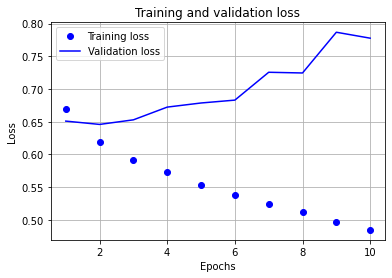

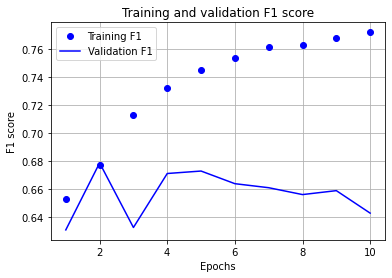

In [ ]:
epochs = range(1, len(history.history['get_f1']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['get_f1'], 'bo', label='Training F1')
plt.plot(epochs, history.history['val_get_f1'], 'b', label='Validation F1')
plt.title("Training and validation F1 score")
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.grid()

We can see that our model overfitted, probably we can solve this problem if we change architecture or add some training data.

Nevertheless, we will use our model on whole dataset to make predictions.

In [ ]:
predictions_train = model.predict(train_data)

In [ ]:
predictions_train = np.where(predictions_train >= 0.5, 1, 0)

In [ ]:
data_train = data.iloc[train_index]

In [ ]:
data_train['predictions'] = predictions_train

<ipython-input-95-47eb388c910d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['predictions'] = predictions_train


In [ ]:
bots_train = data_train[data_train['predictions'] == 1]['annotator_id']

In [ ]:
bots_train = set(bots_train.values)

In [ ]:
len(bots_train)

52

In [ ]:
predictions_test = model.predict(test_data)

In [ ]:
predictions_test = np.where(predictions_test >= 0.5, 1, 0)

In [ ]:
data_test = data.iloc[test_index]

In [ ]:
data_test['predictions'] = predictions_test

<ipython-input-111-b8b014e30582>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predictions'] = predictions_test


In [ ]:
bots_test = data_test[data_test['predictions'] == 1]['annotator_id']

In [ ]:
bots_test = set(bots_test.values)

In [ ]:
len(bots_test)

46

In [ ]:
bots = bots_train.union(bots_test)

In [ ]:
len(bots)

52

In [ ]:
bots_ids = pd.DataFrame(list(bots)).to_csv('bots_ids.csv')